# Initial Exploratory Taxi Trip DataSet

The objective of this notebook is to carry out a final analysis of the taxi trips in Chicago together with the dataset of the weather in Chicago.

## Chicago Coordinates 
-87.6244212, 41.8755616

## 1 Create our environment

### 1.1 Create the Spark Session

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession, SQLContext
from pyspark import SparkConf, SparkContext

In [3]:
sc_conf = SparkConf()

In [4]:
sc_conf.set('spark.driver.port', '62678')
sc_conf.set('spark.rdd.compress', 'True')
sc_conf.set('spark.driver.host', '127.0.0.1')
sc_conf.set('spark.serializer.objectStreamReset', '100')
sc_conf.set('spark.master', 'local[*]')
sc_conf.set('spark.executor.id', 'driver')
sc_conf.set('spark.submit.deployMode', 'client')
sc_conf.set('spark.ui.showConsoleProgress', 'true')
sc_conf.set('spark.app.name', 'pyspark-shell')
sc_conf.set("spark.executor.memory","6g")
sc_conf.set("spark.driver.memory","6g")

In [5]:
sc_conf.getAll()

dict_items([('spark.driver.port', '62678'), ('spark.rdd.compress', 'True'), ('spark.driver.host', '127.0.0.1'), ('spark.serializer.objectStreamReset', '100'), ('spark.master', 'local[*]'), ('spark.executor.id', 'driver'), ('spark.submit.deployMode', 'client'), ('spark.ui.showConsoleProgress', 'true'), ('spark.app.name', 'pyspark-shell'), ('spark.executor.memory', '6g'), ('spark.driver.memory', '6g')])

In [6]:
sc = SparkContext(conf=sc_conf)

In [7]:
sql = SQLContext(sc)

In [8]:
session = sql.sparkSession
session

In [9]:
session.sparkContext.getConf().getAll()

[('spark.executor.memory', '6g'),
 ('spark.driver.port', '62678'),
 ('spark.driver.host', '127.0.0.1'),
 ('spark.driver.memory', '6g'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.app.id', 'local-1556574253198')]

## 2 Load the libraries

In [10]:
%matplotlib inline

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql import functions as F
from pyspark.sql import types as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None

## 3 Read the data

### 2.1 Taxi trips

In [11]:
taxi_schema = StructType([
    StructField("trip_id", StringType(), nullable = True),
    StructField("taxi_id", StringType(), nullable = True),
    StructField("trip_start_timestamp", TimestampType(), nullable = True),
    StructField("trip_end_timestamp", TimestampType(), nullable = True),
    StructField("trip_seconds", IntegerType(), nullable = True),
    StructField("trip_miles", DoubleType(), nullable = True),
    StructField("pickup_community_area", IntegerType(), nullable = True),
    StructField("dropoff_community_area", IntegerType(), nullable = True),
    StructField("fare", DoubleType(), nullable = True),
    StructField("tips", DoubleType(), nullable = True),
    StructField("tolls", DoubleType(), nullable = True),
    StructField("extras", DoubleType(), nullable = True),
    StructField("trip_total", DoubleType(), nullable = True),
    StructField("payment_type", StringType(), nullable = True),
    StructField("company", StringType(), nullable = True),
    StructField("pickup_centroid_latitude", DoubleType(), nullable = True),
    StructField("pickup_centroid_longitude", DoubleType(), nullable = True),
    StructField("dropoff_centroid_latitude", DoubleType(), nullable = True),
    StructField("dropoff_centroid_longitude", DoubleType(), nullable = True)])

In [12]:
taxi_trips = session.read.csv('../Data/chicago_data_clean.csv',
                              header=True,
                              schema=taxi_schema)

In [13]:
taxi_trips.write.parquet("../Data/taxi_trips.parquet")

In [14]:
taxi_trips = session.read.parquet("../Data/taxi_trips.parquet")

#### 2.1.1 Check the correct load 

In [15]:
taxi_trips.show(5)

+--------------------+--------------------+--------------------+-------------------+------------+----------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+-------------------------+--------------------------+
|             trip_id|             taxi_id|trip_start_timestamp| trip_end_timestamp|trip_seconds|trip_miles|pickup_community_area|dropoff_community_area| fare|tips|tolls|extras|trip_total|payment_type|             company|pickup_centroid_latitude|pickup_centroid_longitude|dropoff_centroid_latitude|dropoff_centroid_longitude|
+--------------------+--------------------+--------------------+-------------------+------------+----------+---------------------+----------------------+-----+----+-----+------+----------+------------+--------------------+------------------------+-------------------------+-------------------------+--------------------------+
|fe9a92bfa69619749.

In [16]:
taxi_trips.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- dropoff_centroid_latitude: double (nullable = true)
 |-- dropoff_centroid_longitude: double (nullable = true)



#### 2.1.2 Study the dimensions of the dataset

In [17]:
taxi_trips.count()

29755922

In [18]:
len(taxi_trips.columns)

19

### 2.2 Chicago Weather

In [19]:
weather_schema = StructType([
    StructField("datetime", TimestampType(), nullable = True),
    StructField("humidity", DoubleType(), nullable = True),
    StructField("pressure", DoubleType(), nullable = True),
    StructField("temperature", DoubleType(), nullable = True),
    StructField("weather_description", StringType(), nullable = True),
    StructField("wind_direction", DoubleType(), nullable = True),
    StructField("wind_speed", DoubleType(), nullable = True)])

In [20]:
chicago_weather = session.read.csv('../Data/Chicago_weather.csv.gz',
                              header=True,
                              schema=weather_schema)

In [21]:
chicago_weather.write.parquet("../Data/chicago_weather.parquet")

In [22]:
chicago_weather = session.read.parquet("../Data/chicago_weather.parquet")

#### 2.2.1 Check the correct load

In [23]:
chicago_weather.show(5)

+-------------------+--------+--------+------------------+-------------------+--------------+----------+
|           datetime|humidity|pressure|       temperature|weather_description|wind_direction|wind_speed|
+-------------------+--------+--------+------------------+-------------------+--------------+----------+
|2012-10-01 13:00:00|    71.0|  1014.0|            284.01|    overcast clouds|           0.0|       0.0|
|2012-10-01 14:00:00|    70.0|  1014.0|284.05469097400004|    overcast clouds|           0.0|       0.0|
|2012-10-01 15:00:00|    70.0|  1014.0|     284.177412183|    overcast clouds|           0.0|       0.0|
|2012-10-01 16:00:00|    70.0|  1014.0|     284.300133393|    overcast clouds|           0.0|       0.0|
|2012-10-01 17:00:00|    69.0|  1014.0|284.42285460200003|    overcast clouds|           0.0|       0.0|
+-------------------+--------+--------+------------------+-------------------+--------------+----------+
only showing top 5 rows



In [24]:
chicago_weather.printSchema()

root
 |-- datetime: timestamp (nullable = true)
 |-- humidity: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- weather_description: string (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)



#### 2.2.2 Study the dimensions of the dataset

In [25]:
chicago_weather.count()

45252

In [26]:
len(chicago_weather.columns)

7

## 3 Join both Dataset

### 3.1 Define the keys to join both dataset

#### 3.1.1 Taxi Trips

In [27]:
# We create a computed field from column 'trip_start_timestamp' and convert it to string format with the aim of 
# then crossing by year, month, day and hour with the weather dataset
taxi_trips = taxi_trips.withColumn("AUX_trip_start_timestamp",
                                   F.col("trip_start_timestamp").cast(T.StringType()))

#### 3.1.2 Weather

In [28]:
# We create a computed field from column 'datetime' and convert it to string format with the aim of 
# then crossing by year, month, day and hour with the traxi_trips dataset
chicago_weather = chicago_weather.withColumn("AUX_datetime",
                                             F.col("datetime").cast(T.StringType()))

### 3.2 Join both Datasets

In [29]:
# We cross both datasets by year, month, day and hour
taxi_trips = taxi_trips.join(chicago_weather,
                             on=F.col('AUX_trip_start_timestamp')[0:13]==F.col('AUX_datetime')[0:13],
                             how='left_outer')

#### 3.2.1 Check the correct join of the data

In [30]:
taxi_trips.count()

29760901

After the join, there have been generated duplicates that we must eliminate

In [31]:
len(taxi_trips.columns)

28

In [32]:
taxi_trips.limit(5).toPandas()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,AUX_trip_start_timestamp,datetime,humidity,pressure,temperature,weather_description,wind_direction,wind_speed,AUX_datetime
0,fe9a92bfa6961974922c4df4b1f8ae27727eedd9,970061a1beb6a38b3952054ade845973522e145fa12c49...,2017-05-02 16:45:00,2017-05-02 17:00:00,480,1.5,8,7,7.25,0.0,0.0,1.0,8.25,Cash,Dispatch Taxi Affiliation,41.899602,-87.633308,41.922686,-87.649489,2017-05-02 16:45:00,2017-05-02 16:00:00,65.0,1006.0,280.64,overcast clouds,270.0,8.0,2017-05-02 16:00:00
1,fe9a934b04428c2f8a7776f81ba69e0853f91aa9,34374a0a0e084535388b552992e4ab4c06e7ca58817b77...,2014-02-14 10:30:00,2014-02-14 10:30:00,600,2.2,28,32,8.25,0.0,0.0,0.0,8.25,Cash,Dispatch Taxi Affiliation,41.879067,-87.657005,41.884987,-87.620993,2014-02-14 10:30:00,2014-02-14 10:00:00,72.0,1004.0,262.80,few clouds,270.0,6.0,2014-02-14 10:00:00
2,fe9a935bba33847d9555e37c1d03ccf25182bdd0,68f360f3c1cee4fc86d94c40008040dbffe2915edd3567...,2013-08-04 10:00:00,2013-08-04 10:15:00,1440,1.1,76,31,37.05,0.0,0.0,2.0,39.05,Cash,Taxi Affiliation Services,41.980264,-87.913625,41.850266,-87.667569,2013-08-04 10:00:00,2013-08-04 10:00:00,78.0,1014.0,291.13,overcast clouds,345.0,0.0,2013-08-04 10:00:00
3,fe9a9385ac6d28e2573833a73040f817db32c49e,df713d3e792da0c30d1362aab25c15def59a179a6f4115...,2013-03-31 10:15:00,2013-03-31 10:30:00,600,24.0,8,32,8.85,2.0,0.0,0.0,10.85,Credit Card,Taxi Affiliation Services,41.900266,-87.632109,41.870607,-87.622173,2013-03-31 10:15:00,2013-03-31 10:00:00,72.0,1023.0,272.32,few clouds,69.0,0.0,2013-03-31 10:00:00
4,fe9a939b56e2769b6c283ab65cc8087107ce099a,69d98995876c80f617a2884fac0a9ff87019a3cb7e519c...,2015-07-07 16:45:00,2015-07-07 17:00:00,540,1.5,32,8,7.25,2.0,0.0,0.0,9.25,Credit Card,Taxi Affiliation Services,41.880994,-87.632746,41.891972,-87.612945,2015-07-07 16:45:00,2015-07-07 16:00:00,59.0,1016.0,291.04,overcast clouds,10.0,8.0,2015-07-07 16:00:00


#### 3.2.2 Drop  duplicate trips after the join

In [33]:
taxi_trips = taxi_trips.dropDuplicates(['trip_id',
                                        'taxi_id',
                                        'trip_start_timestamp',
                                        'trip_end_timestamp',
                                        'trip_seconds',
                                        'trip_miles',
                                        'pickup_community_area',
                                        'dropoff_community_area',
                                        'fare',
                                        'tips',
                                        'tolls',
                                        'extras',
                                        'trip_total',
                                        'payment_type',
                                        'company',
                                        'pickup_centroid_latitude',
                                        'pickup_centroid_longitude',
                                        'dropoff_centroid_latitude',
                                        'dropoff_centroid_longitude'])

In [34]:
# We check that the number of duplicate trips have been eliminated
taxi_trips.count()

29755922

#### 3.2.2 Remove useless columns

In [35]:
taxi_trips.columns

['trip_id',
 'taxi_id',
 'trip_start_timestamp',
 'trip_end_timestamp',
 'trip_seconds',
 'trip_miles',
 'pickup_community_area',
 'dropoff_community_area',
 'fare',
 'tips',
 'tolls',
 'extras',
 'trip_total',
 'payment_type',
 'company',
 'pickup_centroid_latitude',
 'pickup_centroid_longitude',
 'dropoff_centroid_latitude',
 'dropoff_centroid_longitude',
 'AUX_trip_start_timestamp',
 'datetime',
 'humidity',
 'pressure',
 'temperature',
 'weather_description',
 'wind_direction',
 'wind_speed',
 'AUX_datetime']

In [36]:
taxi_trips = taxi_trips.drop('datetime',
                             'AUX_datetime')

#### 3.2.3 Check the dataset again

In [37]:
len(taxi_trips.columns)

26

In [38]:
taxi_trips.limit(5).toPandas()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,AUX_trip_start_timestamp,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
0,25aef066b51c7b4c370ce6d1fdd5384f67047c18,d092ee0cb44dc6fa5f6757a7ef07181c4ee3d25eed0bc4...,2014-03-16 01:30:00,2014-03-16 02:00:00,1800,16.1,32,54,58.25,0.0,0.0,4.5,62.75,Cash,Taxi Affiliation Services,41.878866,-87.625192,41.660136,-87.602848,2014-03-16 01:30:00,80.0,1023.0,272.1900,overcast clouds,60.0,7.0
1,375147e3577a7bd56b57b3d00b0c6321f6d765c8,2182f6ccc0b281edf72bc71d682add85a54eae959b5659...,2014-09-18 09:45:00,2014-09-18 10:00:00,1080,18.0,28,54,35.45,0.0,0.0,0.0,35.45,Cash,Choice Taxi Association,41.874005,-87.663518,41.660136,-87.602848,2014-09-18 09:45:00,99.0,1032.0,286.9395,sky is clear,262.0,1.0
2,85a9b45ee947abc2e4f7093b54cd47b71a7e6167,38c926561cf2221a4785159e39aef376ef08ddb3c6081c...,2016-06-18 23:45:00,2016-06-19 00:00:00,960,0.7,38,54,29.00,0.0,0.0,0.0,29.00,Cash,Taxi Affiliation Services,41.812949,-87.617860,41.660136,-87.602848,2016-06-18 23:45:00,36.0,1020.0,301.1800,light rain,77.0,3.0
3,56935737fc8af8ad8b71e0a118586d462bbb5608,fb318ecb67178004b27e8a37d5214da86679b46764daf8...,2016-03-18 13:45:00,2016-03-18 14:15:00,1800,20.9,32,55,51.50,0.0,0.0,0.0,51.50,Cash,Taxi Affiliation Services,41.878866,-87.625192,41.663671,-87.540936,2016-03-18 13:45:00,55.0,1018.0,275.2000,sky is clear,280.0,7.0
4,ab866a97d9f76ef70b081734cf452f705edfc137,12a6836fadda44701b6b28577ea4c56120cf38065701bd...,2016-06-15 10:30:00,2016-06-15 11:15:00,2340,1.5,56,55,61.75,0.0,0.0,4.0,65.75,Cash,Taxi Affiliation Services,41.792592,-87.769615,41.663671,-87.540936,2016-06-15 10:30:00,95.0,1005.0,293.2500,moderate rain,240.0,2.0


In [39]:
taxi_trips.printSchema()

root
 |-- trip_id: string (nullable = true)
 |-- taxi_id: string (nullable = true)
 |-- trip_start_timestamp: timestamp (nullable = true)
 |-- trip_end_timestamp: timestamp (nullable = true)
 |-- trip_seconds: integer (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- pickup_community_area: integer (nullable = true)
 |-- dropoff_community_area: integer (nullable = true)
 |-- fare: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- extras: double (nullable = true)
 |-- trip_total: double (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- company: string (nullable = true)
 |-- pickup_centroid_latitude: double (nullable = true)
 |-- pickup_centroid_longitude: double (nullable = true)
 |-- dropoff_centroid_latitude: double (nullable = true)
 |-- dropoff_centroid_longitude: double (nullable = true)
 |-- AUX_trip_start_timestamp: string (nullable = true)
 |-- humidity: double (nullable = true)
 |-- pressure: do

In [40]:
taxi_trips.write.parquet("../Data/taxi_weather_trips.parquet")

In [41]:
taxi_trips = session.read.parquet("../Data/taxi_weather_trips.parquet")

## 4 Outliers

### 4.1 Get the descriptive statistics of some variables

In [42]:
# We select the variables, we are going to analyze
analysed_variables = ['trip_seconds',
                      'trip_miles',
                      'fare',
                      'tips',
                      'tolls',
                      'extras',
                      'trip_total',
                      'humidity',
                      'pressure',
                      'temperature',
                      'wind_direction',
                      'wind_speed']

# We get the descriptive statistis of these variables
for var in analysed_variables:
    print(var)
    describe = taxi_trips.select(F.round(F.mean(var), 2).alias("mean"),
                                F.min(var).alias("min"),
                                F.max(var).alias("max"),
                                F.round(F.stddev(var), 2).alias("stddv"))
    q1, median, q3 = taxi_trips.approxQuantile(var, [0.25, 0.5, 0.75], 0)
    iqr = q3 - q1
    describe = describe.withColumn("q1", F.lit(q1))
    describe = describe.withColumn("median", F.lit(median))
    describe = describe.withColumn("q3", F.lit(q3))
    describe = describe.withColumn("iqr", F.lit(iqr))
    describe = describe.withColumn("threshold", 1.5*F.lit(iqr))
    describe.show()
    thresholds[var]=[describe.take(1)[0][8],
                           describe.take(1)[0][4],
                           describe.take(1)[0][6]]

In [43]:
# We get the descriptive statistis of these variables
thresholds={}
for var in analysed_variables:
    print(var)
    describe = taxi_trips.select(F.round(F.mean(var), 2).alias("mean"),
                                F.min(var).alias("min"),
                                F.max(var).alias("max"),
                                F.round(F.stddev(var), 2).alias("stddv"))
    q1, median, q3 = taxi_trips.approxQuantile(var, [0.25, 0.5, 0.75], 0)
    iqr = q3 - q1
    describe = describe.withColumn("q1", F.lit(q1))
    describe = describe.withColumn("median", F.lit(median))
    describe = describe.withColumn("q3", F.lit(q3))
    describe = describe.withColumn("iqr", F.lit(iqr))
    describe = describe.withColumn("threshold", 4*F.lit(iqr))
    describe.show()
    describe_list = describe.collect()
    for value in describe_list:
        element = [i for i in value]
        thresholds[var]=[element[8],
                         element[4],
                         element[6]]

trip_seconds
+------+---+-----+------+-----+------+------+-----+---------+
|  mean|min|  max| stddv|   q1|median|    q3|  iqr|threshold|
+------+---+-----+------+-----+------+------+-----+---------+
|883.11|120|83520|757.98|420.0| 660.0|1080.0|660.0|   2640.0|
+------+---+-----+------+-----+------+------+-----+---------+

trip_miles
+----+---+------+-----+---+------+---+---+---------+
|mean|min|   max|stddv| q1|median| q3|iqr|threshold|
+----+---+------+-----+---+------+---+---+---------+
|4.26|0.6|1998.1| 8.58|1.1|   1.8|4.2|3.1|     12.4|
+----+---+------+-----+---+------+---+---+---------+

fare
+-----+----+-------+-----+----+------+-----+---+---------+
| mean| min|    max|stddv|  q1|median|   q3|iqr|threshold|
+-----+----+-------+-----+----+------+-----+---+---------+
|13.55|0.01|3963.92|11.22|6.45|  8.65|14.75|8.3|     33.2|
+-----+----+-------+-----+----+------+-----+---+---------+

tips
+----+---+-----+-----+---+------+---+---+---------+
|mean|min|  max|stddv| q1|median| q3|iqr|

## 4.2 Get the number of outliers and the percentage

In [44]:
outliers = {}
n_rows=taxi_trips.count()
for i in thresholds:
    outlier = taxi_trips.filter(F.col(i) < (thresholds[i][1]-thresholds[i][0])).count() \
    + taxi_trips[F.col(i) > (thresholds[i][2]+thresholds[i][0])].count()
    outliers[i] = [outlier,outlier/n_rows*100]
df_outliers = pd.DataFrame(outliers).T
df_outliers.columns = ['outliers_number','% outliers']
df_outliers

,outliers_number,% outliers
trip_seconds,264643.0,0.889379
trip_miles,2003290.0,6.732408
fare,218973.0,0.735897
tips,325196.0,1.092878
tolls,5399.0,0.018144
extras,113923.0,0.382858
trip_total,680559.0,2.287138
humidity,0.0,0.000000
pressure,3205.0,0.010771
temperature,0.0,0.000000


## 4.3 Plot the outliers

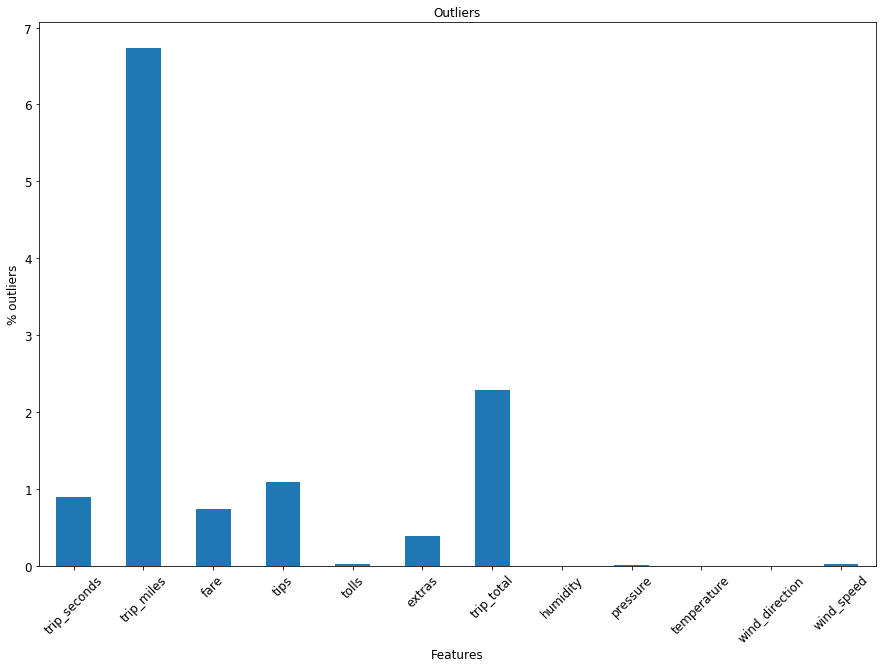

In [45]:
ax=df_outliers['% outliers'].plot(kind='bar', title ="Outliers", figsize=(15, 10), \
                                         fontsize=12, rot=45)
ax.set_xlabel("Features", fontsize=12)
ax.set_ylabel("% outliers", fontsize=12)
plt.show()

taxi_trips = taxi_trips.filter((F.unix_timestamp('trip_end_timestamp', format="MM/dd/yyyy hh:mm:ss aa")
                  - F.unix_timestamp('trip_start_timestamp', format="MM/dd/yyyy hh:mm:ss aa")+1800)\
                  >=F.col('trip_seconds'))

## 4.4 Remove trips with extrange values

### 4.4.1 Number of trips depending on the filter per duration

In [46]:
# We get the number of trips per duration
hours = [1,1.5,2,2.5,3]
dicc_trip_seconds={}
for duration in hours:
    duration = duration * 3600
    dicc_trip_seconds[duration/3600] = [taxi_trips.filter(F.col('trip_seconds') <= duration).count()]

# We convert it to pandas    
trip_duration = (pd.DataFrame(dicc_trip_seconds).T).reset_index()
trip_duration.columns = ['duration_hours','number_trips']
trip_duration

,duration_hours,number_trips
0,1.0,29442674
1,1.5,29724767
2,2.0,29747043
3,2.5,29751696
4,3.0,29753475


### 4.4.2 Number of trips depending on the filter per path length

In [47]:
# We get the number of trips per path length
miles = [10,15,20,50,100]
dicc_trip_miles={}
for length in miles:
    dicc_trip_miles[str(length)] = [taxi_trips.filter(F.col('trip_miles') <= length).count()]

# We convert it to pandas    
trip_length = (pd.DataFrame(dicc_trip_miles).T).reset_index()
trip_length.columns = ['length_miles','number_trips']
trip_length

,length_miles,number_trips
0,10,26093092
1,15,27416807
2,20,29435329
3,50,29697991
4,100,29726312


### 4.4.3 Number of trips depending on the filter per fare

In [48]:
# We get the number of trips per fares
fares = [100,200,500]
dicc_trip_fare={}
for fare in fares:
    dicc_trip_fare[str(fare)] = [taxi_trips.filter(F.col('fare') <= fare).count()]

# We convert it to pandas    
trip_fare = (pd.DataFrame(dicc_trip_fare).T).reset_index()
trip_fare.columns = ['fares_$','number_trips']
trip_fare

,fares_$,number_trips
0,100,29752238
1,200,29755613
2,500,29755889


### 4.4.4 Number of trips depending on the filter per toll

In [49]:
# We get the number of trips per tolls
tolls = [5,10,20,50,100]
dicc_trip_toll={}
for toll in tolls:
    dicc_trip_toll[str(toll)] = [taxi_trips.filter(F.col('tolls') <= toll).count()]

# We convert it to pandas    
trip_toll = (pd.DataFrame(dicc_trip_toll).T).reset_index()
trip_toll.columns = ['tolls_$','number_trips']
trip_toll

,tolls_$,number_trips
0,5,29755583
1,10,29755847
2,20,29755881
3,50,29755896
4,100,29755908


### 4.4.5 Number of trips depending on the filter per extra

In [50]:
# We get the number of trips per extra
extras = [5,10,20,50,100,1000]
dicc_trip_extra={}
for extra in extras:
    dicc_trip_extra[str(extra)] = [taxi_trips.filter(F.col('extras') <= extra).count()]

# We convert it to pandas    
trip_extra = (pd.DataFrame(dicc_trip_extra).T).reset_index()
trip_extra.columns = ['extras_$','number_trips']
trip_extra

,extras_$,number_trips
0,5,29641999
1,10,29738954
2,20,29750726
3,50,29753959
4,100,29754810
5,1000,29755146


### 4.4.6 Number of trips depending per type of payment

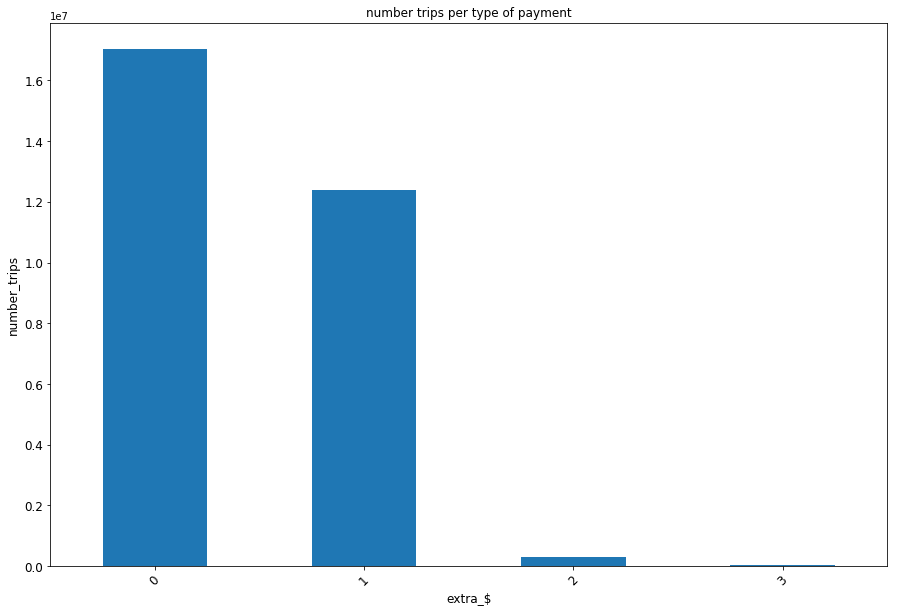

In [51]:
# We get the number of trips per payment
payment_type = taxi_trips.groupby("payment_type").count().sort('count',ascending=False).toPandas()

# We convert it to pandas    
payment_type.columns = ['payment_type','number_trips']

# Plot it
ax = payment_type['number_trips'].plot(kind='bar', title ="number trips per type of payment", figsize=(15, 10), \
                                         fontsize=12, rot=45)
ax.set_xlabel("extra_$", fontsize=12)
ax.set_ylabel("number_trips", fontsize=12)
plt.show()

### 4.4.7 Filter the trips

In [52]:
# We filter the dataframe after our study
print('Number of trips with outliers: ',taxi_trips.count())
taxi_trips = taxi_trips.filter((F.col('trip_seconds') <= 3600)& 
                  ((F.col('trip_miles')<=100)|((F.col('trip_miles')>=100)&(F.col('trip_seconds') >= 2700)))&
                  (F.col('fare') <= 100)&
                  (F.col('fare')>F.col('tips'))&
                  (F.col('tips') <= (0.4*F.col('fare')))&
                  (F.col('tolls')<=20)&
                  (F.col('extras')<=20))
print('Number of trips without outliers: ',taxi_trips.count())

Number of trips with outliers:  29755922
Number of trips without outliers:  28392241


After our analysis we will delete the trips with trips in dispute or no charge to model it

## 5 Exploratory data analysis

taxi_trips = taxi_trips.sample(fraction=0.1,seed=42)

In [53]:
taxi_trips.write.parquet("../Data/taxi_df.parquet")

In [54]:
taxi_trips = session.read.parquet("../Data/taxi_df.parquet")

### 5.1 Analysis trips, fare and  tip per year, year-month and day of week

#### 5.1.1 Year

In [55]:
df_trips_year = taxi_trips.groupby(F.year("trip_start_timestamp").alias("year"))\
                          .agg(F.count('taxi_id').alias('trips_number'),
                               F.sum('fare').alias('total_fare'),
                               F.sum('tips').alias('total_tips'),                               
                               F.mean('tips').alias('tips_mean'))\
                          .sort('year').toPandas()

##### 5.1.1.1 Number of trips by year

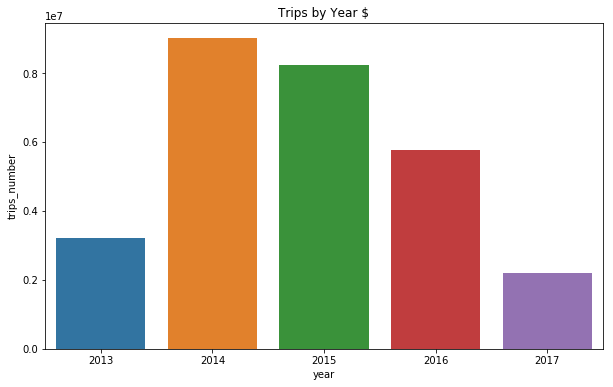

In [56]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=df_trips_year["year"], y=df_trips_year["trips_number"]).set_title('Trips by Year $');

##### 5.1.1.2 Total fare by year

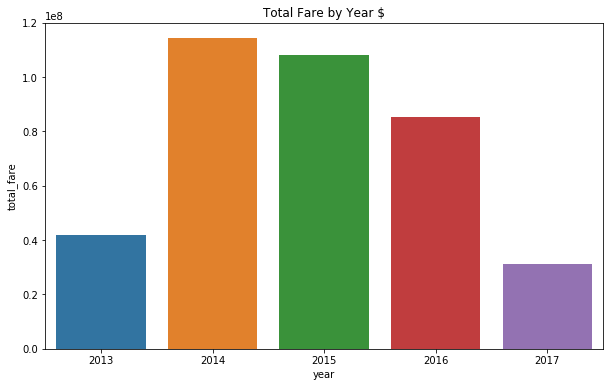

In [57]:
f, axes = plt.subplots( sharey=True, figsize=(10, 6))
sns.barplot(x=df_trips_year["year"], y=df_trips_year['total_fare']).set_title('Total Fare by Year $');

##### 5.1.1.3 Total tips by year

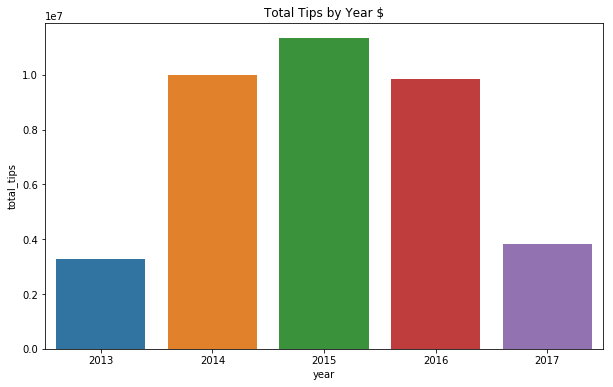

In [58]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=df_trips_year["year"], y=df_trips_year["total_tips"]).set_title('Total Tips by Year $');

##### 5.1.1.4 Mean of tips per year

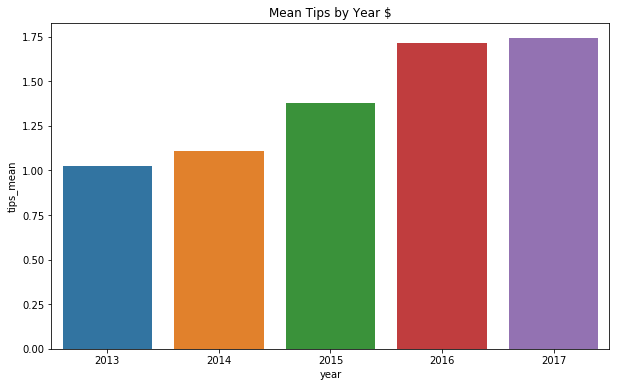

In [59]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=df_trips_year["year"], y=df_trips_year["tips_mean"]).set_title('Mean Tips by Year $');

#### 5.1.2 Year - Month

In [60]:
df_trips_year_month = taxi_trips.groupby(F.col('AUX_trip_start_timestamp')[0:7].alias('year_month'))\
                          .agg(F.count('taxi_id').alias('trips_number'),
                               F.sum('fare').alias('total_fare'),
                               F.sum('tips').alias('total_tips'),                               
                               F.mean('tips').alias('tips_mean'))\
                          .sort('year_month').toPandas()

##### 5.1.2.1 Number of trips by year-month

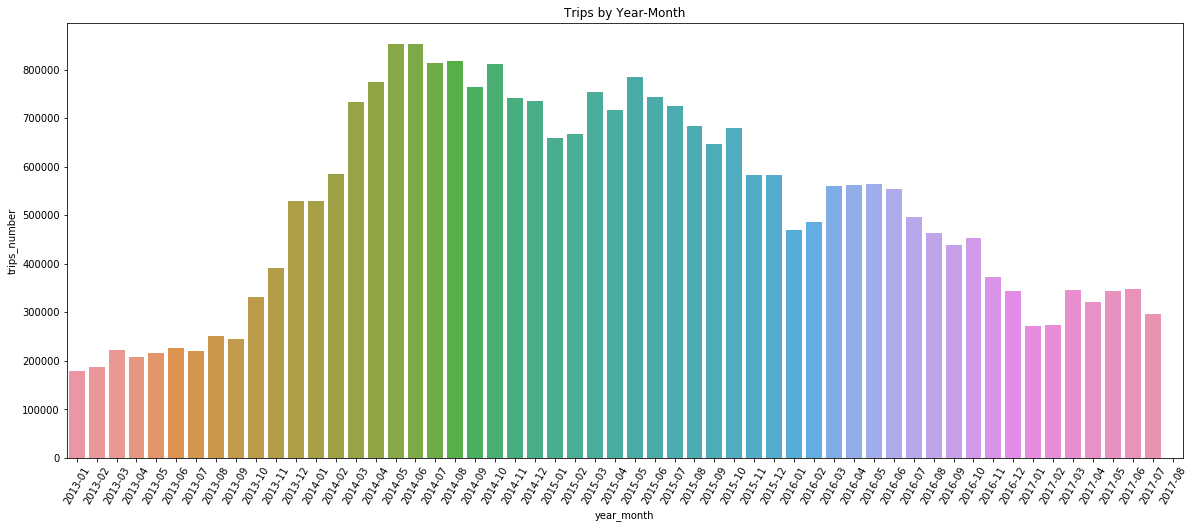

In [61]:
f, axes = plt.subplots(sharey=True, figsize=(20, 8))
sns.barplot(x=df_trips_year_month["year_month"], 
            y=df_trips_year_month["trips_number"]).set_title('Trips by Year-Month')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.1.1.2 Total fare by year-month

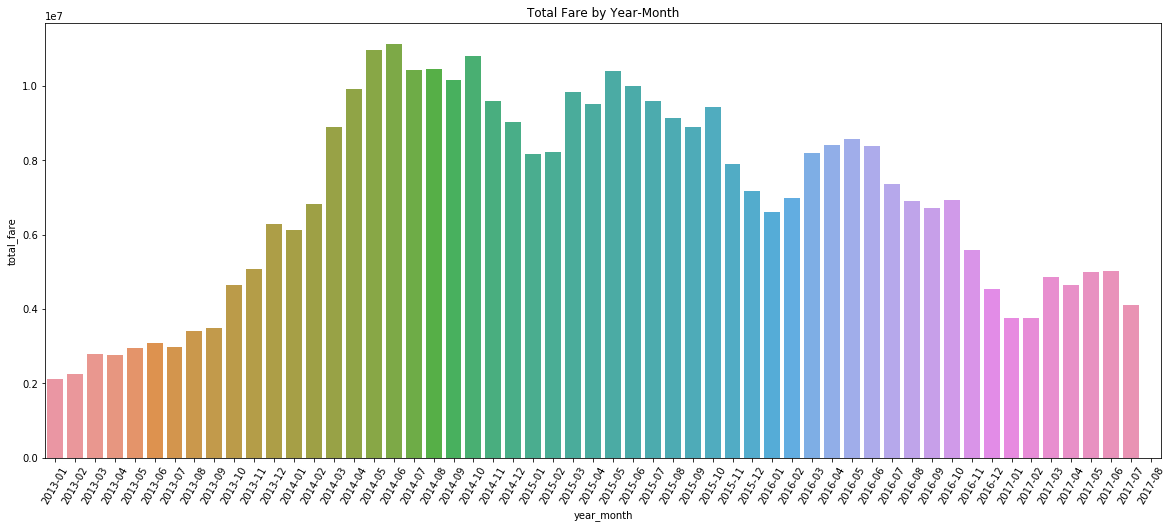

In [62]:
f, axes = plt.subplots(sharey=True, figsize=(20, 8))
sns.barplot(x=df_trips_year_month["year_month"], 
            y=df_trips_year_month["total_fare"]).set_title('Total Fare by Year-Month')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.1.2.3 Total tips by month

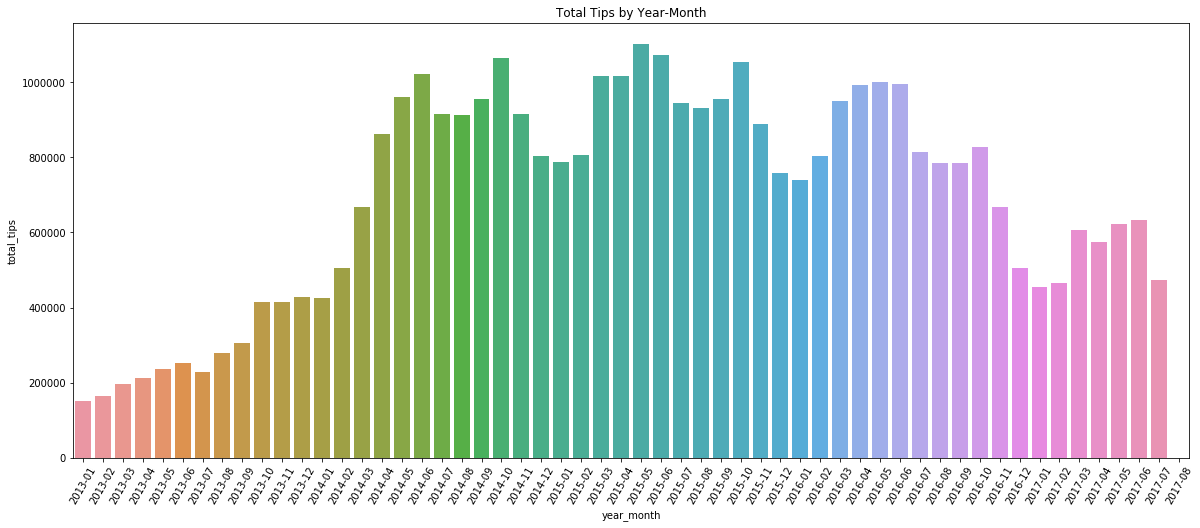

In [63]:
f, axes = plt.subplots(sharey=True, figsize=(20, 8))
sns.barplot(x=df_trips_year_month["year_month"], 
            y=df_trips_year_month["total_tips"]).set_title('Total Tips by Year-Month')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.1.2.4 Mean tips by month

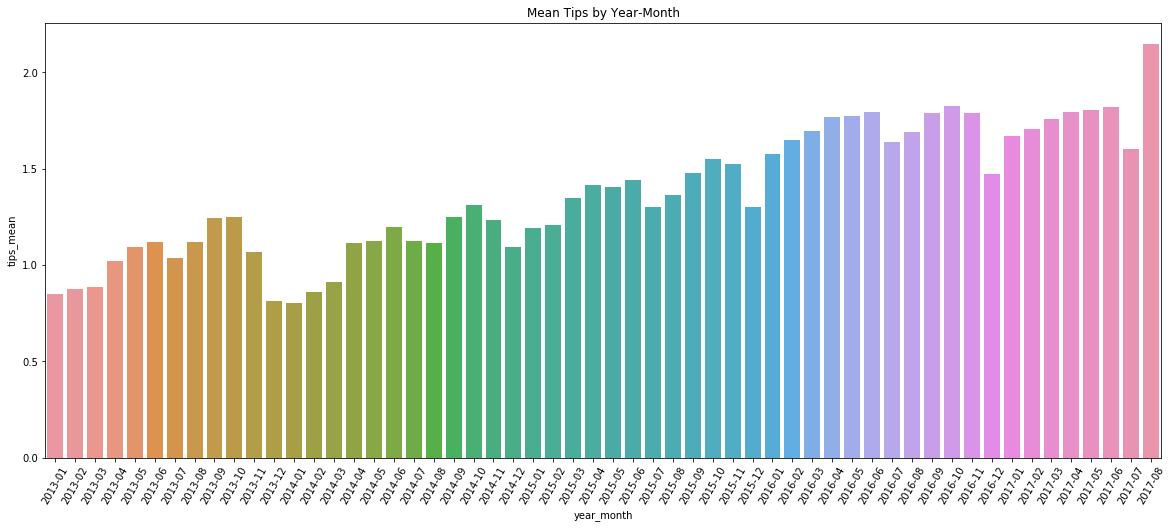

In [64]:
f, axes = plt.subplots(sharey=True, figsize=(20, 8))
sns.barplot(x=df_trips_year_month["year_month"], 
            y=df_trips_year_month["tips_mean"]).set_title('Mean Tips by Year-Month')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.1.3 WeekDay

In [65]:
df_trips_dayweek = taxi_trips.groupby(F.dayofweek("trip_start_timestamp").alias("dayweek"))\
                          .agg(F.count('taxi_id').alias('trips_number'),
                               F.sum('fare').alias('total_fare'),
                               F.sum('tips').alias('total_tips'),
                               F.mean('tips').alias('tips_mean'))\
                          .sort('dayweek').toPandas()

##### 5.1.3.1 Number of trips by weekday

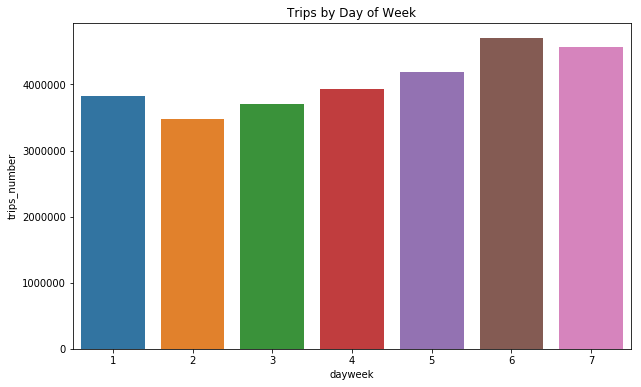

In [66]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=df_trips_dayweek["dayweek"], y=df_trips_dayweek["trips_number"]).set_title('Trips by Day of Week');

#### 5.1.3.2 Total of fare by day of week

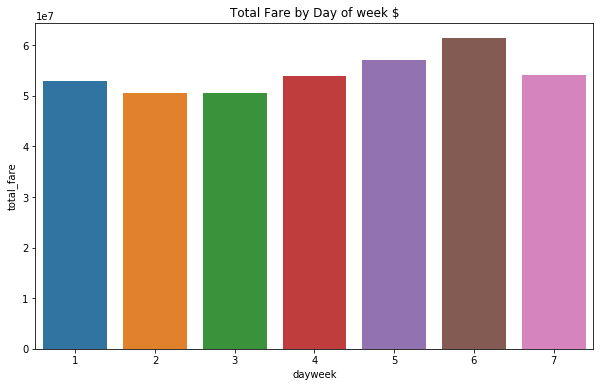

In [67]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=df_trips_dayweek["dayweek"],
            y=df_trips_dayweek['total_fare']).set_title('Total Fare by Day of week $');

#### 5.1.3.3 Total of tips by day of week

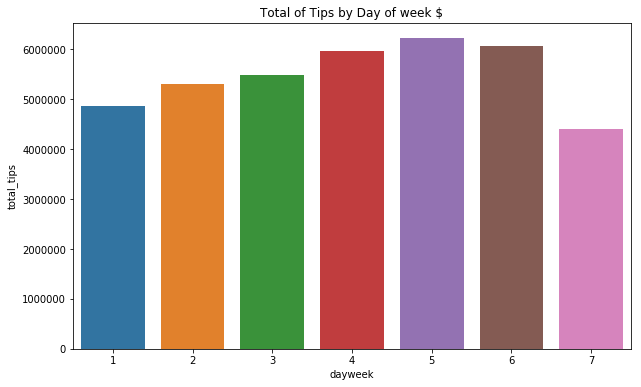

In [68]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=df_trips_dayweek["dayweek"],
            y=df_trips_dayweek['total_tips']).set_title('Total of Tips by Day of week $');

In [69]:
taxi_trips.limit(2).toPandas()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,fare,tips,tolls,extras,trip_total,payment_type,company,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,AUX_trip_start_timestamp,humidity,pressure,temperature,weather_description,wind_direction,wind_speed
0,17c5513869e70d8b13bd0f867e25093277e66490,02ed22eae97d54edcd84d5546ca287aeb086bb46cfc12e...,2016-02-22 15:15:00,2016-02-22 16:15:00,3420,1.1,56,54,50.25,0.0,0.0,5.0,55.25,Cash,Taxi Affiliation Services,41.792592,-87.769615,41.660136,-87.602848,2016-02-22 15:15:00,80.0,1022.0,274.060000,mist,54.0,2.0
1,496ed6a3d29b6f10e65288d71ff839a958710e3e,a3460f34db4558e799a895b6468d4730cc1e69f1cfd780...,2015-05-16 10:30:00,2015-05-16 11:15:00,2340,23.3,7,54,47.05,0.0,0.0,1.0,48.05,Cash,Dispatch Taxi Affiliation,41.922686,-87.649489,41.660136,-87.602848,2015-05-16 10:30:00,83.0,1029.0,285.782333,scattered clouds,172.0,2.0


### 5.2 Analysis trips, fare, trip miles and trip duratinon by company

In [70]:
df_company = taxi_trips.groupby(F.col('company'))\
                          .agg(F.count('taxi_id').alias('trips_number'),
                               F.sum('fare').alias('total_fare'),
                               F.mean('fare').alias('fare_mean'),                               
                               F.mean('tips').alias('tips_mean'),
                               F.mean('trip_miles').alias('miles_mean'),
                               F.lit(F.mean('trip_seconds')/60).alias('duration_mean'))

#### 5.2.1 TOP 10 Total Trips by Company

In [71]:
company_trips = df_company.sort('trips_number',ascending=False).limit(10).toPandas()
company_trips

,company,trips_number,total_fare,fare_mean,tips_mean,miles_mean,duration_mean
0,Taxi Affiliation Services,12282824,1.745618e+08,14.211841,1.421602,4.217479,15.042493
1,Dispatch Taxi Affiliation,6593185,7.953855e+07,12.063729,1.162642,3.941599,13.015117
2,Choice Taxi Association,3768826,4.923743e+07,13.064396,1.462052,4.381395,14.063563
3,Northwest Management LLC,2310484,2.736808e+07,11.845173,1.154844,3.787711,13.067729
4,KOAM Taxi Association,1287161,1.647145e+07,12.796725,1.202305,4.177149,13.935964
5,Top Cab Affiliation,812440,1.056165e+07,12.999917,1.146560,4.217252,13.810755
6,Chicago Medallion Leasing INC,329834,4.214278e+06,12.776966,1.351881,3.839286,13.366260
7,Blue Ribbon Taxi Association Inc.,313007,1.006373e+07,32.105527,4.036771,1.676139,30.617205
8,Chicago Medallion Management,244799,3.004126e+06,12.271805,1.211729,3.524006,13.076471
9,3201 - C&D Cab Co Inc,15222,1.682760e+05,11.054792,0.950626,3.421272,12.623965


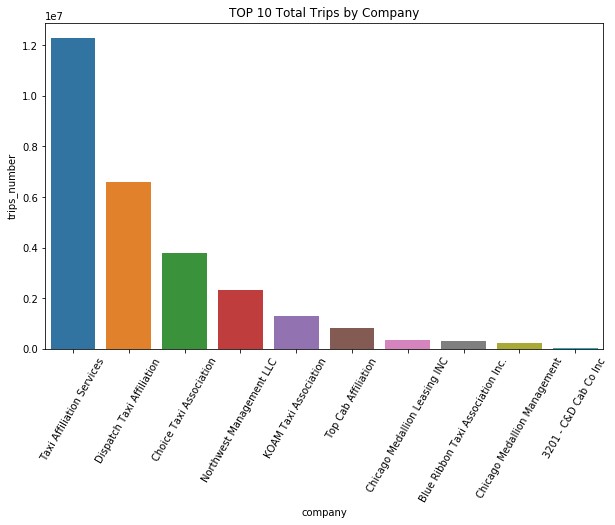

In [72]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=company_trips["company"],
            y=company_trips['trips_number']).set_title('TOP 10 Total Trips by Company')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.2.2 TOP 10 Total Fare by Company

In [73]:
company_total_fare = df_company.sort('total_fare',ascending=False).limit(10).toPandas()
company_total_fare

,company,trips_number,total_fare,fare_mean,tips_mean,miles_mean,duration_mean
0,Taxi Affiliation Services,12282824,1.745618e+08,14.211841,1.421602,4.217479,15.042493
1,Dispatch Taxi Affiliation,6593185,7.953855e+07,12.063729,1.162642,3.941599,13.015117
2,Choice Taxi Association,3768826,4.923743e+07,13.064396,1.462052,4.381395,14.063563
3,Northwest Management LLC,2310484,2.736808e+07,11.845173,1.154844,3.787711,13.067729
4,KOAM Taxi Association,1287161,1.647145e+07,12.796725,1.202305,4.177149,13.935964
5,Top Cab Affiliation,812440,1.056165e+07,12.999917,1.146560,4.217252,13.810755
6,Blue Ribbon Taxi Association Inc.,313007,1.006373e+07,32.105527,4.036771,1.676139,30.617205
7,Chicago Medallion Leasing INC,329834,4.214278e+06,12.776966,1.351881,3.839286,13.366260
8,Chicago Medallion Management,244799,3.004126e+06,12.271805,1.211729,3.524006,13.076471
9,0118 - 42111 Godfrey S.Awir,13402,1.860279e+05,13.880607,1.303558,4.512088,14.972094


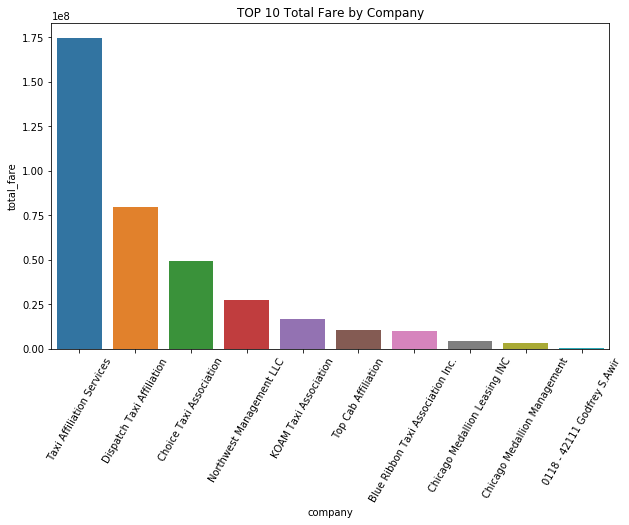

In [74]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=company_total_fare["company"],
            y=company_total_fare['total_fare']).set_title('TOP 10 Total Fare by Company')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.2.3 TOP 10 Mean Fare by Company

In [75]:
company_mean_fare = df_company.sort('fare_mean',ascending=False).limit(10).toPandas()
company_mean_fare

,company,trips_number,total_fare,fare_mean,tips_mean,miles_mean,duration_mean
0,4732 - Maude Lamy,2,77.75,38.875000,0.000000,14.050000,32.500000
1,3669 - 85800 Jordan Taxi Inc,487,16342.25,33.556982,3.236222,13.418686,30.934292
2,Blue Ribbon Taxi Association Inc.,313007,10063734.35,32.105527,4.036771,1.676139,30.617205
3,"2241 - 44667 - Felman Corp, Manuel Alonso",582,17296.50,29.719072,4.833797,11.277835,30.489691
4,2241 - 44667 Manuel Alonso,2306,60900.85,26.409735,4.136921,11.123114,29.449696
5,2823 - 73307 Lee Express Inc,1466,36686.00,25.024557,3.908499,8.728445,25.887449
6,Chicago Independents,1098,26868.50,24.470401,3.432131,7.093443,18.883424
7,2241 - Manuel Alonso,799,18211.55,22.792929,2.768185,9.787735,25.702128
8,4053 - 40193 Adwar H. Nikola,4690,99918.55,21.304595,3.118548,8.285394,19.943284
9,"3721 - Santamaria Express, Alvaro Santamaria",709,13827.75,19.503173,3.118322,5.999295,17.341326


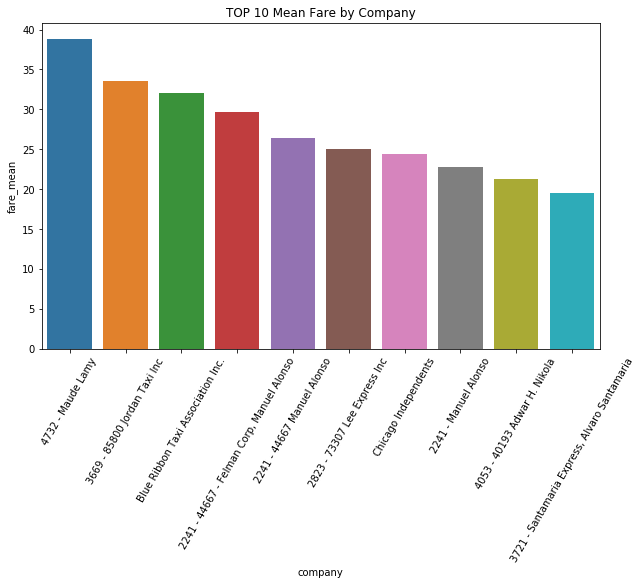

In [76]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=company_mean_fare["company"],
            y=company_mean_fare['fare_mean']).set_title('TOP 10 Mean Fare by Company')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.2.4 TOP 10 Mean Tips by Company

In [77]:
company_mean_tips = df_company.sort('tips_mean',ascending=False).limit(10).toPandas()
company_mean_tips

,company,trips_number,total_fare,fare_mean,tips_mean,miles_mean,duration_mean
0,"2241 - 44667 - Felman Corp, Manuel Alonso",582,17296.50,29.719072,4.833797,11.277835,30.489691
1,2241 - 44667 Manuel Alonso,2306,60900.85,26.409735,4.136921,11.123114,29.449696
2,Blue Ribbon Taxi Association Inc.,313007,10063734.35,32.105527,4.036771,1.676139,30.617205
3,2823 - 73307 Lee Express Inc,1466,36686.00,25.024557,3.908499,8.728445,25.887449
4,Chicago Independents,1098,26868.50,24.470401,3.432131,7.093443,18.883424
5,3669 - 85800 Jordan Taxi Inc,487,16342.25,33.556982,3.236222,13.418686,30.934292
6,4053 - 40193 Adwar H. Nikola,4690,99918.55,21.304595,3.118548,8.285394,19.943284
7,"3721 - Santamaria Express, Alvaro Santamaria",709,13827.75,19.503173,3.118322,5.999295,17.341326
8,2241 - Manuel Alonso,799,18211.55,22.792929,2.768185,9.787735,25.702128
9,4623 - 27290 Jay Kim,7424,126671.05,17.062372,2.394328,6.097710,17.790409


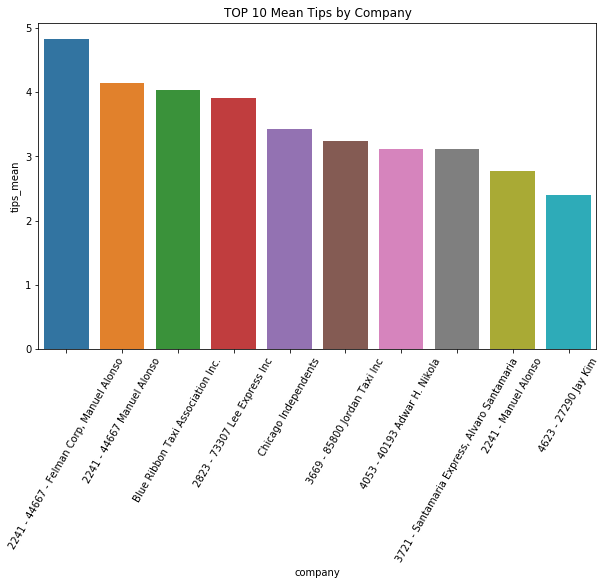

In [78]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=company_mean_tips["company"],
            y=company_mean_tips['tips_mean']).set_title('TOP 10 Mean Tips by Company')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.2.5 TOP 10 Longest Trips(miles) by Company

In [79]:
company_lenght_mean = df_company.sort('miles_mean',ascending=False).limit(10).toPandas()
company_lenght_mean

,company,trips_number,total_fare,fare_mean,tips_mean,miles_mean,duration_mean
0,4732 - Maude Lamy,2,77.75,38.875000,0.000000,14.050000,32.500000
1,3669 - 85800 Jordan Taxi Inc,487,16342.25,33.556982,3.236222,13.418686,30.934292
2,"2241 - 44667 - Felman Corp, Manuel Alonso",582,17296.50,29.719072,4.833797,11.277835,30.489691
3,2241 - 44667 Manuel Alonso,2306,60900.85,26.409735,4.136921,11.123114,29.449696
4,2241 - Manuel Alonso,799,18211.55,22.792929,2.768185,9.787735,25.702128
5,2823 - 73307 Lee Express Inc,1466,36686.00,25.024557,3.908499,8.728445,25.887449
6,4053 - 40193 Adwar H. Nikola,4690,99918.55,21.304595,3.118548,8.285394,19.943284
7,1408 - 89599 Donald Barnes,1462,27557.45,18.849145,1.960178,7.704172,21.176471
8,2823 - 73307 Seung Lee,3664,68913.35,18.808229,2.353450,7.336326,21.588155
9,Chicago Independents,1098,26868.50,24.470401,3.432131,7.093443,18.883424


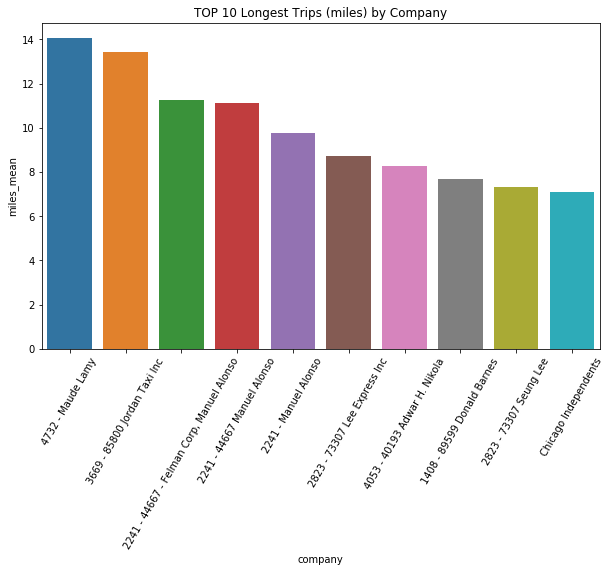

In [80]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=company_lenght_mean["company"],
            y=company_lenght_mean['miles_mean']).set_title('TOP 10 Longest Trips (miles) by Company')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

#### 5.2.6 TOP 10 Longest Trips(minutes) by Company

In [81]:
company_duration_mean = df_company.sort('duration_mean',ascending=False).limit(10).toPandas()
company_duration_mean

,company,trips_number,total_fare,fare_mean,tips_mean,miles_mean,duration_mean
0,4732 - Maude Lamy,2,77.75,38.875000,0.000000,14.050000,32.500000
1,3669 - 85800 Jordan Taxi Inc,487,16342.25,33.556982,3.236222,13.418686,30.934292
2,Blue Ribbon Taxi Association Inc.,313007,10063734.35,32.105527,4.036771,1.676139,30.617205
3,"2241 - 44667 - Felman Corp, Manuel Alonso",582,17296.50,29.719072,4.833797,11.277835,30.489691
4,2241 - 44667 Manuel Alonso,2306,60900.85,26.409735,4.136921,11.123114,29.449696
5,2823 - 73307 Lee Express Inc,1466,36686.00,25.024557,3.908499,8.728445,25.887449
6,2241 - Manuel Alonso,799,18211.55,22.792929,2.768185,9.787735,25.702128
7,2823 - 73307 Seung Lee,3664,68913.35,18.808229,2.353450,7.336326,21.588155
8,1408 - 89599 Donald Barnes,1462,27557.45,18.849145,1.960178,7.704172,21.176471
9,2823 - Seung Lee,335,5757.15,17.185522,1.231493,6.712239,20.731343


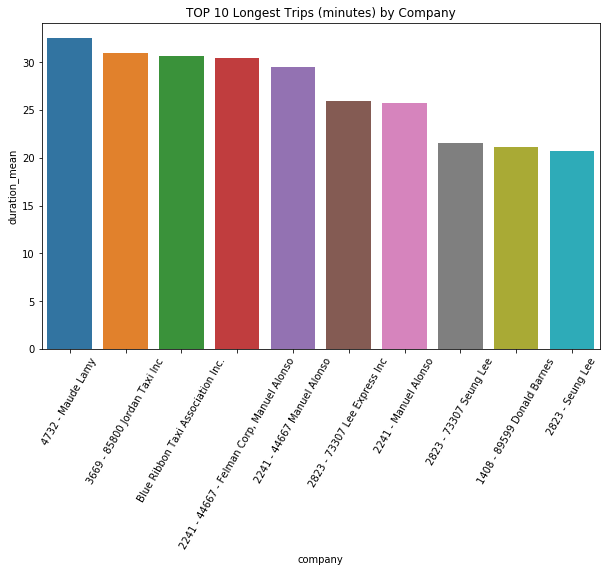

In [82]:
f, axes = plt.subplots(sharey=True, figsize=(10, 6))
sns.barplot(x=company_duration_mean["company"],
            y=company_duration_mean['duration_mean']).set_title('TOP 10 Longest Trips (minutes) by Company')
axes.set_xticklabels(axes.get_xticklabels(), rotation = 60);

Except "Blue Ribbon Taxi Association Inc. the rest of the companies that collect the most, that make the most trips, that hahave highest mean fares, that make the longest trips are not among the 10 companies with the highest average fare.